## Pipeline Quiz Generator (Separate Quiz and Distractor Approach)

Description: Quiz Generator with separate pipeline for quiz generation and then distractor generator

### Step 1 : SciQ Loading

Load dataset

In [1]:
from datasets import load_dataset

sciq_dataset = load_dataset("allenai/sciq")
sciq_dataset

DatasetDict({
    train: Dataset({
        features: ['question', 'distractor3', 'distractor1', 'distractor2', 'correct_answer', 'support'],
        num_rows: 11679
    })
    validation: Dataset({
        features: ['question', 'distractor3', 'distractor1', 'distractor2', 'correct_answer', 'support'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['question', 'distractor3', 'distractor1', 'distractor2', 'correct_answer', 'support'],
        num_rows: 1000
    })
})

In [2]:
filtered_sciq = sciq_dataset.filter(lambda example: example["support"] != '')
filtered_dataset = sciq_dataset.filter(lambda example: example['support'] is not None and example['support'] != "")
# And include only questions with no superfluous information
filtered_dataset = filtered_dataset.filter(lambda example: len(example['question']) < 171)
# And remove any datapoints which contain questions that have a 'fill-in-the-blank' type answer
filtered_sciq = filtered_dataset.filter(lambda example: '_______' not in example['question'] and '______' not in example['question'] and '_____' not in example['question'] and '____' not in example['question'] and '___' not in example['question'])
filtered_sciq 

DatasetDict({
    train: Dataset({
        features: ['question', 'distractor3', 'distractor1', 'distractor2', 'correct_answer', 'support'],
        num_rows: 10263
    })
    validation: Dataset({
        features: ['question', 'distractor3', 'distractor1', 'distractor2', 'correct_answer', 'support'],
        num_rows: 864
    })
    test: Dataset({
        features: ['question', 'distractor3', 'distractor1', 'distractor2', 'correct_answer', 'support'],
        num_rows: 867
    })
})

In [3]:
import pandas as pd
df_train = pd.DataFrame(filtered_sciq["train"].shuffle())
df_train.head()

,question,distractor3,distractor1,distractor2,correct_answer,support
0,The work-energy theorem states that the net wo...,residual energy,binary energy,new energy,kinetic energy,How the Work-Energy Theorem Applies Now let us...
1,"What is considered to be the ""fundamental unit...",bacteria,proton,organ,cell,It could easily be said that a cell is the fun...
2,What is the name of the group that rats are ap...,Mammels,primates,Animals,rodents,"Rats are mammals, but this class can be divide..."
3,What characteristics of an organism help it su...,Changes,systems,additions,adaptations,Some of the characteristics an organism has ma...
4,Screws move objects to a higher elevation by i...,kinetic energy,velocity,torque,force applied,The spiral staircase in Figure below also cont...


Check for support with longer than 512 tokens/words (Maximum token of T5).

In [4]:
print(df_train['support'].str.len().max())

3559


In [5]:
test = filtered_sciq.filter(lambda example: len(example["support"]) > 3000) 
test

DatasetDict({
    train: Dataset({
        features: ['question', 'distractor3', 'distractor1', 'distractor2', 'correct_answer', 'support'],
        num_rows: 9
    })
    validation: Dataset({
        features: ['question', 'distractor3', 'distractor1', 'distractor2', 'correct_answer', 'support'],
        num_rows: 0
    })
    test: Dataset({
        features: ['question', 'distractor3', 'distractor1', 'distractor2', 'correct_answer', 'support'],
        num_rows: 0
    })
})

In [6]:
test_data = test['train'][7]
test_data['support']

"would not be surprised if the surviving populations experienced serious bottlenecks. The subsequent diversification of the surviving organisms, such as the Dinosauria (which includes the extinct dinosaurs and modern birds) and the Cynodontia, which includes the ancestors of modern mammals, including us, could be due in part to these bottleneck-associated effects, for example, through the removal of competing species or predators. An astreroid impact, known as the Cretaceous-Tertiary event, occurred ~65 million years ago; it contributed to the extinction of the dinosaurs and led to the diversification of mammals (which had first appeared in the fossil record ~160 million years ago). While surviving an asteroid impact (or other dramatic changes in climate) may be random, in other cases who survives a bottleneck is not. Consider the effects of a severe drought or highly virulent bacterial or viral infection; the organisms that survive may have specific phenotypes (and associated genotype

We can see above that support is long but only a few sentences is relevant, we cannot do raw summarization, we have to extract text based on keywords which are answers (distractors and keywords from questions too!). If we left this, support and answer will be truncated. If we summarize it raw, we lose important info of what is asked.

Extractive Summarization based on answer and questions

In [7]:
import yake

def extract_question(question):
    kw_extractor = yake.KeywordExtractor(top=10, stopwords=None)
    keywords = kw_extractor.extract_keywords(question)
    return [keyword for keyword, score in keywords]

In [8]:
import spacy

nlp = spacy.load("en_core_web_sm")

def clean_text(text):
    lemmatizer = nlp.get_pipe("lemmatizer")
    doc = nlp(text)
    tokens = [tok for tok in doc]
    lemmas = [tok.lemma_ for tok in tokens]
    return ' '.join(lemmas)

In [9]:
def score_sentence(sentence, words):
    score = 0
    clean_sentences = clean_text(sentence.lower())
    for word in words:
        if clean_text(word.lower()) in clean_sentences:
            score += 1
    return score

In [10]:
def summarize_support(example, max_words=256):
    text = example["support"]
    words = extract_question(example["question"])
    words.extend([test_data["correct_answer"]])

    scored_sentences = (
        (i, sentence, score_sentence(sentence, words))
        for i, sentence in enumerate(text.split("."))
        if any(clean_text(w.lower()) in clean_text(sentence.lower()) for w in words)
    )
    ranked_sentences = sorted(scored_sentences, key=lambda x: x[2], reverse=True)

    sentence_in_summary = []
    sum_of_words = 0
    for order, sentence, _ in ranked_sentences:
        num_of_words = len(sentence.split())
        if sum_of_words + num_of_words < max_words:
            sentence_in_summary.append((order, sentence))
            sum_of_words += num_of_words 

    summary = sorted(sentence_in_summary, key=lambda x: x[1])
    return ".".join(sent for _, sent in summary)

summarize_support(test_data)

' (↓) Comparing genotypes, that is, neutral polymorphisms, between 119. Its rate can be estimated, at least roughly, by comparing the genotypes of individuals of different populations whose time of separation can be accurately estimated (assuming of course that there has been no migrations between the populations). These so-called neutral polymorphisms are expected to accumulate in the regions of the genome between genes (intragenic regions) at a constant rate over time (can you suggest why?) The rate of the accumulation of neutral polymorphisms serves as a type of population-based biological clock.120 Once established, groups of modern humans migrated within and out of African, undergoing a series of founder effect events between ~45,000 to 60,000 years ago first as they migrated from southern Africa into the regions of the Horn of Africa, then into the Arabian peninsula, and from there into Europe, Asia, Oceania, and finally the Americas'

In [11]:
def generate_context_with_question(example, max_token_size=512):
    answer_size = len(example['correct_answer'].split())
    question_size = len(example['question'].split())
    support_size = len(example['support'].split())

    # Add into account separator (<sep>) which are 2
    words_len = answer_size + support_size + question_size + 2
    context = example['support']

    if words_len > max_token_size:
        max_new_token_size = max_token_size - answer_size - question_size - 2
        context = summarize_support(example, max_words=max_new_token_size)
    
    return {
        "context": context
    }

preprocessed_sciq = filtered_sciq.map(generate_context_with_question, num_proc=4)

In [12]:
preprocessed_sciq.save_to_disk("preprocessed_sciq-dg-512-new-RUTGER")

Saving the dataset (0/1 shards):   0%|          | 0/10263 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/864 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/867 [00:00<?, ? examples/s]

Now preprocessed has shorter context for long ones, due to map process running slow, uncomment below after getting zip file from me

In [13]:
# from datasets import load_from_disk
# preprocessed_sciq = load_from_disk("preprocessed_sciq-dg-512-new")

### Step 2 Distractor Generation

#### Tokenize for Distractor Generation

Input : Context and Answer and Question
Output : 3 Distractors

In [16]:
import torch
import copy
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

MODEL_NAME = "google/flan-t5-small"

tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-small")

In [60]:
def preprocess_dataset(example):
    text = "Generate distractors for question: {}, answer: {}, context: {}".format(example['question'], example['correct_answer'], example['context'])
    distractor = "Distractors: {}, {}, {}".format(example['distractor1'], example['distractor2'], example['distractor3'])

    max_length = 512
    max_length_target=32
    
    tokenized_inputs = tokenizer(text, max_length=max_length, padding='max_length', truncation=True, return_tensors="pt")
    tokenized_targets = tokenizer(distractor, max_length=max_length_target, padding='max_length', truncation=True, return_tensors="pt")
    
    input_ids = tokenized_inputs['input_ids'].squeeze()
    input_attention = tokenized_inputs['attention_mask'].squeeze()

    target_ids = tokenized_targets['input_ids'].squeeze()
    target_attention = tokenized_targets['attention_mask'].squeeze()
    outputs = {
        'input_ids':input_ids, 
        'attention_mask': input_attention, 
        'labels': target_ids 
    }

    return outputs
    
tokenized_dataset = preprocessed_sciq.map(preprocess_dataset, remove_columns= ['question', 'distractor3', 'distractor1', 'distractor2', 'correct_answer', 'support', 'context'])
tokenized_dataset

Map:   0%|          | 0/10263 [00:00<?, ? examples/s]

Map:   0%|          | 0/864 [00:00<?, ? examples/s]

Map:   0%|          | 0/867 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 10263
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 864
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 867
    })
})

In [61]:
tokenized_dataset.set_format("torch")

In [63]:
import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW
from transformers import get_scheduler
from transformers import T5ForConditionalGeneration

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-small").to(device)

train_dataloader = DataLoader(tokenized_dataset["train"], shuffle=True, batch_size=8)
eval_dataloader = DataLoader(tokenized_dataset["validation"], batch_size=2)
test_dataloader = DataLoader(tokenized_dataset["test"], batch_size=2)

optimizer = AdamW(model.parameters(), lr=1e-5)

num_epochs = 10
num_training_steps = num_epochs * len(train_dataloader)

lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

In [64]:
class EarlyStopping:
    def __init__(self, tolerance=3, min_delta=0.5):

        self.tolerance = tolerance
        self.min_delta = min_delta
        self.counter = 0
        self.early_stop = False

    def __call__(self, train_loss, validation_loss):
        if (validation_loss - train_loss) > self.min_delta:
            self.counter +=1
            if self.counter >= self.tolerance:  
                self.early_stop = True

In [65]:
torch.cuda.empty_cache()

In [66]:
import evaluate
from tqdm.auto import tqdm

def validate(model, eval_dataloader):
    metric = evaluate.load("accuracy")
    model.eval()
    progress_bar_val = tqdm(range(len(eval_dataloader)), leave=False)
    
    total_loss = 0
    total_batches = 0
    for batch in eval_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)
        logits = outputs.logits
        active_loss = batch["labels"].view(-1) != tokenizer.pad_token_id
        active_logits = logits.view(-1, model.config.vocab_size)[active_loss]
        active_labels = batch["labels"].view(-1)[active_loss]
        loss = torch.nn.functional.cross_entropy(active_logits, active_labels)
        total_loss += loss.item()
        total_batches += 1
        predictions = torch.argmax(logits, dim=-1)
        preds_flatten = torch.flatten(predictions)
        refs_flatten = torch.flatten(batch["labels"])
        metric.add_batch(predictions=preds_flatten, references=refs_flatten)
        progress_bar_val.update(1)
    average_loss = total_loss/total_batches
    val_accuracy = metric.compute()
    progress_bar_val.close()
    return average_loss, val_accuracy['accuracy']

In [137]:
def train(model, train_dataloader, eval_dataloader, num_training_steps, num_epochs):
    progress_bar = tqdm(range(num_training_steps), unit="batch")
    early_stopping = EarlyStopping()
    model.train()

    history = []
    
    for epoch in range(num_epochs):
        running_loss = 0
        total_batches = 0
        for batch in train_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(input_ids=batch["input_ids"], labels=batch["labels"])
            logits = outputs.logits
            active_loss = batch["labels"].view(-1) != tokenizer.pad_token_id
            active_logits = logits.view(-1, model.config.vocab_size)[active_loss]
            active_labels = batch["labels"].view(-1)[active_loss]
            loss = torch.nn.functional.cross_entropy(active_logits, active_labels)

            predictions = torch.argmax(logits, dim=-1)
            preds_flatten = torch.flatten(predictions)
            refs_flatten = torch.flatten(batch["labels"])
            
            loss.backward()
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
            running_loss += loss.item()
            total_batches += 1
            progress_bar.set_description(f"Epoch {epoch + 1}")
            progress_bar.update(1)
        train_loss = running_loss/total_batches
        val_loss, val_acc = validate(model, eval_dataloader)
        
        torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'train_loss': train_loss,
                'val_loss': val_loss,
            }, 'flan-T5-finetuned-dg-{}-run-context'.format(epoch + 11))
        
        print("Epoch {} : Training Loss {} Val Loss {} Val Acc {}%".format(epoch + 1, train_loss, val_loss, val_acc))

        history.append((train_loss, val_loss))
        
        early_stopping(train_loss, val_loss)
        if early_stopping.early_stop:
          print("We are at epoch:", epoch)
          break

    return model, history

In [ ]:
model, history = train(model, train_dataloader, eval_dataloader, num_training_steps, num_epochs)

Early stopped manually at epoch 6, best model is at epoch 3 

In [69]:
history

[(2.3074604242180627, 2.024561939140161),
 (1.8998920473379728, 1.9423575278509546),
 (1.833051116040974, 1.908637441970684),
 (1.7893838651089211, 1.884109921063538),
 (1.7561161939928704, 1.873801680488719),
 (1.729378885156181, 1.8638761584405545),
 (1.7094095301460868, 1.8599473062764715),
 (1.6943051865206784, 1.8569478474005505),
 (1.6838763919735178, 1.8558226124280028),
 (1.6778534264278337, 1.8550197614563837)]

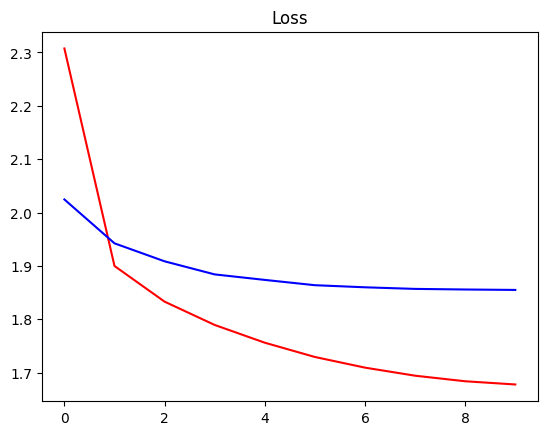

In [70]:
import matplotlib.pyplot as plt

train_loss, val_loss = zip(*history)

plt.plot(train_loss, color = 'r')
plt.plot(val_loss, color = 'b')

# Optionally, add labels and a title
plt.title('Loss')

# Display the plot
plt.show()

In [138]:
model = T5ForConditionalGeneration.from_pretrained(MODEL_NAME).to(device)
model.load_state_dict(torch.load('flan-T5-finetuned-dg-10-run-context')['model_state_dict'])

model, history = train(model, train_dataloader, eval_dataloader, num_training_steps, num_epochs)

  0%|          | 0/12830 [00:00<?, ?batch/s]

  0%|          | 0/432 [00:00<?, ?it/s]

Epoch 1 : Training Loss 2.0069628035938565 Val Loss 1.8550197614563837 Val Acc 0.2933666087962963%


  0%|          | 0/432 [00:00<?, ?it/s]

Epoch 2 : Training Loss 1.6764463536551661 Val Loss 1.8550197614563837 Val Acc 0.2933666087962963%


KeyboardInterrupt: 

In [139]:
def evaluate_model(model, test_dataloader):
    metric_bleu = evaluate.load("bleu")
    model.eval()
    progress_bar_test = tqdm(range(len(test_dataloader)), leave=False)

    for batch in test_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)

        preds_flatten = torch.flatten(predictions)
        refs_flatten = torch.flatten(batch["labels"])

        preds_questions = tokenizer.batch_decode(preds_flatten, skip_special_tokens=True, clean_up_tokenization_spaces=True)
        refs_questions = tokenizer.batch_decode(refs_flatten, skip_special_tokens=True, clean_up_tokenization_spaces=True)
        
        metric_bleu.add_batch(predictions=preds_questions, references=refs_questions)
        progress_bar_test.update(1)
    test_bleu = metric_bleu.compute()
    progress_bar_test.close()
    return test_bleu

model = T5ForConditionalGeneration.from_pretrained(MODEL_NAME).to(device)
model.load_state_dict(torch.load('flan-T5-finetuned-dg-12-run-context')['model_state_dict'])

evaluate_model(model, test_dataloader)

  0%|          | 0/434 [00:00<?, ?it/s]

{'bleu': 0.0,
 'precisions': [0.2761684367122608, 0.2222222222222222, 0.0, 0.0],
 'brevity_penalty': 1.0,
 'length_ratio': 2.3731489653819753,
 'translation_length': 24199,
 'reference_length': 10197}

In [152]:
def inference(model, question, answer, context):
    text = "Generate distractors for question: {}, answer: {}, context: {}".format(question, answer, context)
    max_length = 512
    tokenized_inputs = tokenizer.encode_plus(text, max_length=max_length, padding='max_length', truncation=True, return_tensors="pt").to(device) 
    decoder_input_ids = tokenized_inputs['input_ids']

    output = model.generate(
        input_ids=tokenized_inputs['input_ids']
    )
    
    distractors = tokenizer.batch_decode(output, skip_special_tokens=True, clean_up_tokenization_spaces=True)
    return distractors

test = preprocessed_sciq['test'][800]
test

{'question': "How many mass extinctions have occurred throughout earth's history?",
 'distractor3': 'three',
 'distractor1': 'six',
 'distractor2': 'four',
 'correct_answer': 'five',
 'support': 'Extinction is the complete dying out of a species. Once a species goes extinct, it can never return. More than 99 percent of all the species that ever lived on Earth have gone extinct. Five mass extinctions have occurred in Earth’s history. They were caused by major geologic and climatic events. The fifth mass extinction wiped out the dinosaurs 65 million years ago.',
 'context': 'Extinction is the complete dying out of a species. Once a species goes extinct, it can never return. More than 99 percent of all the species that ever lived on Earth have gone extinct. Five mass extinctions have occurred in Earth’s history. They were caused by major geologic and climatic events. The fifth mass extinction wiped out the dinosaurs 65 million years ago.'}

In [153]:
inference(model, test['question'], test['correct_answer'], test['context'])

['Distractors: two, three, four']

In [136]:
test_data = preprocessed_sciq['test']
def run_inference(test_data):
    count = 0
    for idx, test in enumerate(test_data):
        distractors = inference(model, test['question'], test['correct_answer'], test['context'])
        distractors_arr = distractors[0].split(', ')
        distractors_arr[0] = distractors_arr[0].replace('Distractors: ', '')
        if len(distractors_arr) > 2 and distractors_arr[0] != distractors_arr[1] and distractors_arr[0] != distractors_arr[2] and distractors_arr[1] != distractors_arr[2]:
            print(distractors_arr)
            print(test_data[idx])
            print(idx)
            count += 1
    return count
run_inference(test_data)

['avertism', 'a symbiotic', 'a']
{'question': 'Vertebrata are characterized by the presence of what?', 'distractor3': 'Thumbs', 'distractor1': 'Bones', 'distractor2': 'Muscles', 'correct_answer': 'backbone', 'support': 'Figure 29.7 Vertebrata are characterized by the presence of a backbone, such as the one that runs through the middle of this fish. All vertebrates are in the Craniata clade and have a cranium. (credit: Ernest V. More; taken at Smithsonian Museum of Natural History, Washington, D.', 'context': 'Figure 29.7 Vertebrata are characterized by the presence of a backbone, such as the one that runs through the middle of this fish. All vertebrates are in the Craniata clade and have a cranium. (credit: Ernest V. More; taken at Smithsonian Museum of Natural History, Washington, D.'}
2
['lungs', 'liver', 'kidney']
{'question': 'Digestion of proteins begins with acids in what organ?', 'distractor3': 'brain', 'distractor1': 'colon', 'distractor2': 'liver', 'correct_answer': 'stomach',

KeyboardInterrupt: 

In [27]:
from huggingface_hub import notebook_login

notebook_login()

In [144]:
model.push_to_hub("distractor-generation")

model.safetensors:   0%|          | 0.00/308M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/rizkiduwinanto/distractor-generation/commit/ca9be0bd6cb9c1fe4420a17cd5e121ebd31c61ed', commit_message='Upload T5ForConditionalGeneration', commit_description='', oid='ca9be0bd6cb9c1fe4420a17cd5e121ebd31c61ed', pr_url=None, pr_revision=None, pr_num=None)